In [3]:
import os
import time
import numpy as np
import pandas as pd
from scipy.stats import kendalltau
from src.lexrank import degree_centrality_scores

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('ticks')

from config import *
from helpers import *
from visualization import *
from redundancy import *
from relevance import *

In [10]:
DATASET_ID = DATASET_IDS[0]
DATA_DIR = '/scratch/korunosk/data'
SCORES_DIR = 'scores'
EMBEDDINGS_DIR = os.path.join(DATA_DIR, 'BERT_sent')

## Experiments

In [5]:
def load_and_extract_topic(data_dir, topic_id):
    topic = load_data(data_dir, topic_id, encoded=True)
    return extract(topic)

In [6]:
def execute_experiment(data_dir, tac, experiment):
    data   = [ load_and_extract_topic(data_dir, topic_id) for topic_id in tac ]
    scores = [ experiment(d) for d in data ]

    return np.array(scores)

In [7]:
def experiment_average_pairwise_distance(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    metric = lambda i: average_pairwise_distance(np.array(summary_embs[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

def experiment_semantic_volume(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])
    metric = lambda i: semantic_volume(np.array(summary_pts[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

def experiment_semantic_spread(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    metric = lambda i: semantic_spread(np.array(summary_embs[i[0]:i[1]]))
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

def experiment_word_mover_distance(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    document_hist = []
    # document_hist = np.empty(document_embs.shape[0])
    # document_hist.fill(1 / document_embs.shape[0])
    metric = lambda i: word_mover_distance(document_embs, np.array(summary_embs[i[0]:i[1]]), document_hist)
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

def experiment_lex_rank(data):
    document_embs, summary_embs, indices, pyr_scores, summary_ids = data
    document_embs = np.array(document_embs)
    lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))
    metric = lambda i: lex_rank(document_embs, np.array(summary_embs[i[0]:i[1]]), lr_scores)
    return kendalltau(pyr_scores, np.array([metric(i) for i in indices]))[0]

## Scores

In [6]:
scores = [
    {
        'label': 'Average Pairwise Distance',
        'experiment': experiment_average_pairwise_distance 
    },
    {
        'label': 'Semantic Volume',
        'experiment': experiment_semantic_volume 
    },
    {
        'label': 'Semantic Spread',
        'experiment': experiment_semantic_spread 
    },
    {
        'label': 'Word Mover Distance',
        'experiment': experiment_word_mover_distance 
    },
    {
        'label': 'LexRank',
        'experiment': experiment_lex_rank 
    }
]

ptr = ''
print(f'=== Experiments {DATASET} ===\n')
for i,s in enumerate(scores):
    print('Executing "{}"'.format(s['label']))
    start = time.time()
    scores[i]['values'] = execute_experiment(os.path.join(EMBEDDINGS_DIR, DATASET), TOPICS[DATASET], s['experiment'])
    print('*** Elapsed: {:}\n'.format(format_time(time.time() - start)))
    ptr += '{:30} {:.4}\n'.format(s['label'], np.mean(scores[i]['values']))
    del s['experiment']
print('\n=== Results ===\n')
print(ptr)

=== Experiments TAC2008 ===

Executing "Average Pairwise Distance"
*** Elapsed: 0:00:06

Executing "Semantic Volume"
*** Elapsed: 0:00:05

Executing "Semantic Spread"
*** Elapsed: 0:00:04

Executing "Word Mover Distance"
*** Elapsed: 0:00:06

Executing "LexRank"
*** Elapsed: 0:00:07


=== Results ===

Average Pairwise Distance      -0.0157
Semantic Volume                0.04086
Semantic Spread                0.02711
Word Mover Distance            -0.04924
LexRank                        0.06159



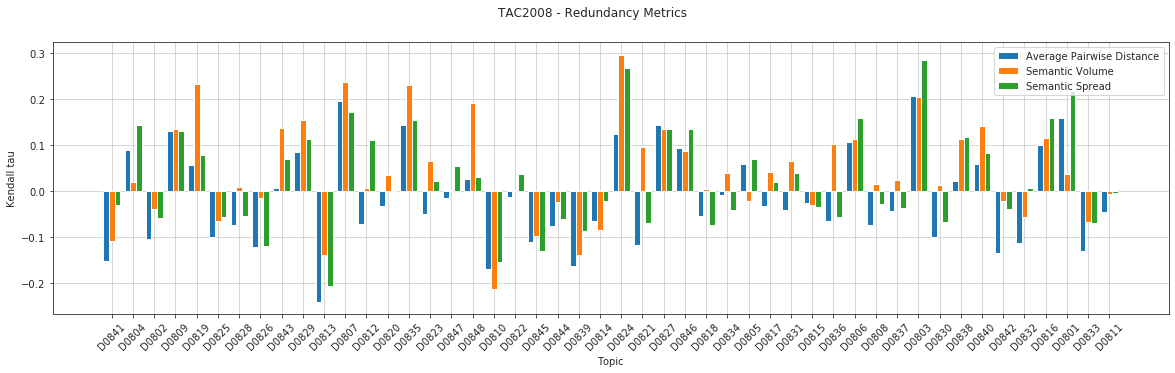

In [7]:
fig = plt.figure(figsize=(20,5))
fig.suptitle(f'{DATASET} - Redundancy Metrics')
ax = fig.add_subplot(1,1,1)
plot_corr_coeff(ax, TOPICS[DATASET], scores[:3])
plt.legend(loc='upper right')
plt.grid()
plt.show()

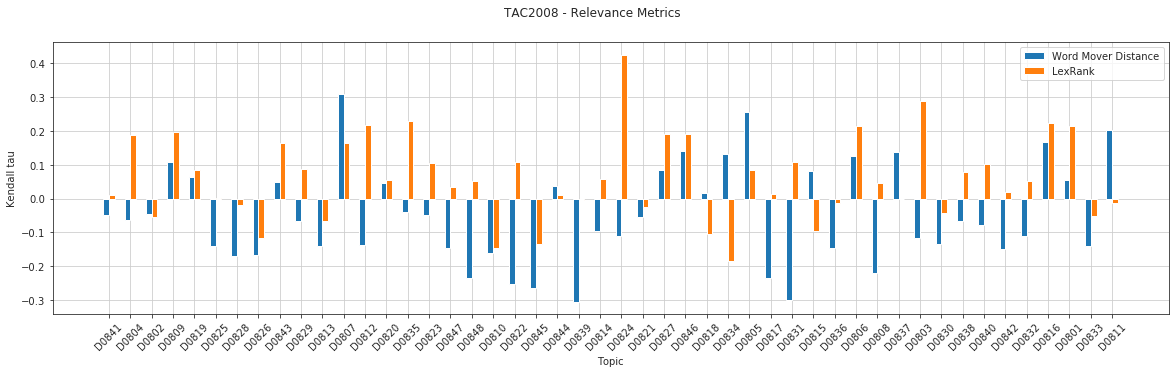

In [8]:
fig = plt.figure(figsize=(20,5))
fig.suptitle(f'{DATASET} - Relevance Metrics')
ax = fig.add_subplot(1,1,1)
plot_corr_coeff(ax, TOPICS[DATASET], scores[3:])
plt.legend(loc='upper right')
plt.grid()
plt.show()

## Experimental

### Make data

In [13]:
data = []

for dataset_id in DATASET_IDS:
    print(dataset_id)
    for topic_id in TOPIC_IDS[dataset_id]:
        document_embs, summary_embs, indices, pyr_scores, summary_ids = load_and_extract_topic(os.path.join(EMBEDDINGS_DIR, dataset_id), topic_id)
        document_embs = np.array(document_embs)

        document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])
        lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))

        for p,i in enumerate(indices):
            data.append({
                'Dataset ID': dataset_id,
                'Topic ID': topic_id,
                'Summary ID': summary_ids[p],
                'Average Pairwise Distance': average_pairwise_distance(np.array(summary_embs[i[0]:i[1]])),
                'Semantic Volume': semantic_volume(np.array(summary_pts[i[0]:i[1]])),
                'Semantic Spread': semantic_spread(np.array(summary_embs[i[0]:i[1]])),
                'Word Mover Distance': word_mover_distance(document_embs, np.array(np.array(summary_embs[i[0]:i[1]]))),
                'LexRank': lex_rank(document_embs, np.array(summary_embs[i[0]:i[1]]), lr_scores),
                'Pyramid Score': pyr_scores[p]
            })

df = pd.DataFrame(data, columns=data[0].keys())

df.to_csv(os.path.join(SCORES_DIR, 'baselines.csv'), index=False)

TAC2008
TAC2009


In [10]:
def fix(df):
    df = df.corr(method='kendall').loc['Pyramid Score']
    df.name = ''
    return df.drop('Pyramid Score')
df_tmp = df.groupby(['Dataset ID', 'Topic ID']).apply(fix).reset_index()
df_tmp.groupby('Dataset ID').mean()

/home/korunosk/.conda/envs/dlab/lib/python3.7/site-packages/pandas/core/groupby/groupby.py:4315: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  stacked_values = np.vstack(map(np.asarray, values))


,Average Pairwise Distance,Semantic Volume,Semantic Spread,Word Mover Distance,LexRank
Dataset ID,,,,,
TAC2008,-0.015701,0.040861,0.027107,-0.049240,0.061593
TAC2009,0.119815,0.167713,0.159819,-0.040908,0.198115


In [11]:
df_tmp = df[df['Dataset ID'] == DATASET]

In [12]:
def print_sentences(summary):
    for i, sentence in enumerate(summary):
        print('{:3}. {}'.format(i+1, sentence))

In [13]:
tac = load_data(DATA_DIR, DATASET, encoded=False)

In [16]:
# Topic ID with high correlation coefficient (chosen from the plot above)
TOPIC_ID = 'D0824'
documents, summaries, indices, _, summary_ids = extract(tac[TOPIC_ID])

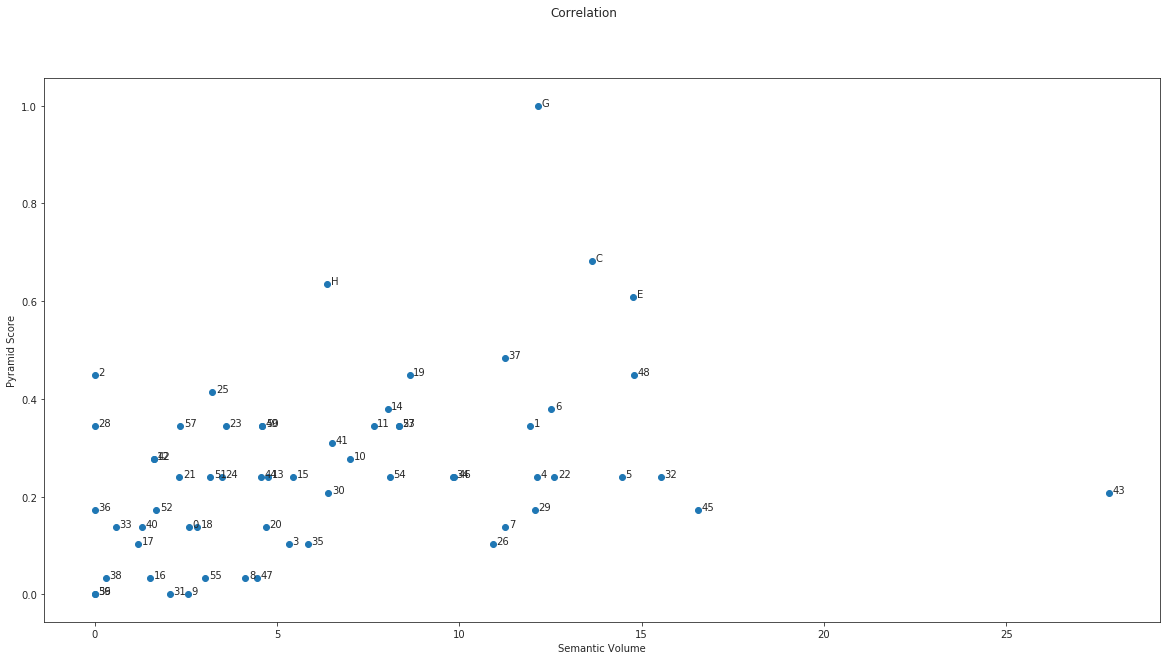

In [17]:
# Scatter plot of metric vs Pyramid score
fig = plt.figure(figsize=(20,10))
fig.suptitle('Correlation')
ax = fig.add_subplot(1,1,1)
plot_corr(ax, df_tmp, TOPIC_ID, 'Semantic Volume')
plt.show()

In [18]:
# Print sentences in summary where the metric and the Pyramid score agree
SUMMARY_ID = int(np.where(np.array(summary_ids) == 'G')[0])
print_sentences(summaries[indices[SUMMARY_ID][0]:indices[SUMMARY_ID][1]])

  1. Developmental drug SR-13668 curbs the oncogene protein AKT, prevalent in cancer patients; and SR-16158 reduces breast cancer patient heart disease risk.
  2. Aromatase inhibitors lessen breast cancer recurrence with fewer side effects than tamoxifen.
  3. Radiation therapy no longer carries heart disease risk.
  4. Olive oil suppresses oncogene Her-2/neu and boosts effectiveness of antibody Herceptin.
  5. Hypothyroidism and oral contraceptives reduce breast cancer risk.
  6. Sisters are being studied to investigate environmental and genetic affects on cancer risk.
  7. Deficiency in cell DNA repair-ability accelerates genetic changes leading to cancer.
  8. Protein markers in genes help predict cancer recurrence.
  9. Ductal lavage proved unreliable for detecting early cancer.


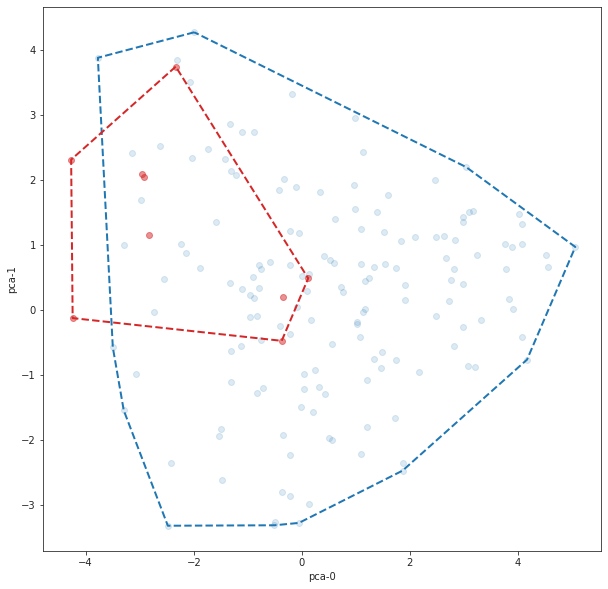

In [19]:
# Plot projection of such summary
document_embs, summary_embs, indices, _, _ = load_and_extract_topic(os.path.join(EMBEDDINGS_DIR, DATASET), TOPIC_ID)
document_embs = np.array(document_embs)

document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(1,1,1)
plot_hull(ax1, '', 'pca', document_pts, summary_pts[indices[SUMMARY_ID][0]:indices[SUMMARY_ID][1]])
plt.show()

### Why do certain summaries have 0 Pyramid score?

In [21]:
# Ratio between the number of summaries with 0 Pyramid score and the ones with > 0 Pyramid score
df_tmp[df_tmp['Pyramid Score'] == 0].groupby('Topic ID').apply(len) / df_tmp[df_tmp['Pyramid Score'] > 0].groupby('Topic ID').apply(len) * 100

Topic ID
D0801    14.814815
D0802     1.639344
D0803          NaN
D0804     1.639344
D0805    17.307692
D0806          NaN
D0807          NaN
D0808          NaN
D0809          NaN
D0810     1.639344
D0811     1.639344
D0812    14.814815
D0813     5.084746
D0814     5.084746
D0815     3.333333
D0816          NaN
D0817     3.333333
D0818     5.084746
D0819          NaN
D0820          NaN
D0821     3.333333
D0822     1.639344
D0823          NaN
D0824     6.896552
D0825    21.568627
D0826     3.333333
D0827     6.896552
D0828     1.639344
D0829     1.639344
D0830     6.896552
D0831     5.084746
D0832    12.727273
D0833    16.981132
D0834     1.639344
D0835     8.771930
D0836    10.714286
D0837     8.771930
D0838     1.639344
D0839     1.639344
D0840     6.896552
D0841     1.639344
D0842     1.639344
D0843     6.896552
D0844     1.639344
D0845          NaN
D0846     8.771930
D0847     3.333333
D0848          NaN
dtype: float64

In [22]:
# Summaries with 0 Pyramid score
df_tmp[df_tmp['Pyramid Score'] == 0].head()

,Dataset ID,Topic ID,Summary ID,Average Pairwise Distance,Semantic Volume,Semantic Spread,Word Mover Distance,LexRank,Pyramid Score
8,TAC2008,D0841,8,7.141869,4.094222,1.197091e+09,8.695851,8.040533,0.0
100,TAC2008,D0804,38,3.977950,0.000000,9.811452e+03,9.030172,2.930773,0.0
157,TAC2008,D0802,33,5.056581,0.461180,3.706337e+05,8.850674,5.762191,0.0
318,TAC2008,D0825,8,7.855877,11.222428,2.781220e+09,8.748028,8.516494,0.0
319,TAC2008,D0825,9,8.955182,4.590404,3.022384e+11,9.634648,9.270865,0.0


In [26]:
# Print sentences in summaries with 0 Pyramid score, per topic
for topic_id, df_group in df_tmp[df_tmp['Pyramid Score'] == 0].groupby('Topic ID'):
    print(f'=== {DATASET} ===\n')
    for _, row in df_group.iterrows():
        document_embs, summary_embs, indices, _, _ = load_and_extract_topic(os.path.join(EMBEDDINGS_DIR, DATASET), topic_id)
        summary_id = int(np.where(np.array(summary_ids) == row['Summary ID'])[0])
        print(f'   Summary ID: {summary_id}\n')
        print_sentences(summaries[indices[summary_id][0]:indices[summary_id][1]])
        print()

=== TAC2008 ===

   Summary ID: 1

  1. Deficiencies in the ability of cells to repair damaged DNA are associated with an increased risk  of breast cancer, researchers at Columbia University said Monday.
  2. A new U.S. study will investigate genetic and environmental causes of breast cancer by enrolling 50,000 sisters of women already diagnosed with the disease.
  3. Olive oil can help fight breast  cancer, a discovery that researchers said in a study out Sunday  could guide the development of related treatment.
  4. Deficient DNA repair  capacity was associated with a twofold increase in the risk of  breast cancer.

   Summary ID: 9

  1. Breast cancer, like ovarian cancer, is a "silent killer" of women.
  2. Therapies being studied to help decrease breast cancer:    Menendez said the findings should not only help in understanding the molecular mechanisms by which individual dietary fatty acids regulate the malignant behavior of breast cancer cells, but also suggested eating oleic ac

   Summary ID: 28

  1. The two medicines have been tested on animals in the United States and have been shown to be effective in inhibiting the growth of cancer cells the officials said.
  2. But tamoxifen can be taken only for five years and increases the risk of uterine cancer and blood clots that can cause strokes.
  3. Fatty acid previously suggested to be protective against breast cancer significantly downregulates the expression of Her2/neu.
  4. Before they could be spotted on
  5. Local researchers have found that radiation therapy likely no longer leaves breast cancer patients at increased risk of potentially deadly heart disease.

   Summary ID: 39

  1. Local researchers have found that radiation therapy likely no longer leaves breast cancer patients at an increased risk of potentially deadly heart disease.
  2. Giordano and colleagues studied the records of more than 27,000 women treated for breast cancer from 1973 to 1989 -- 13,998 with cancer in the left breast (near
  3

   Summary ID: 9

  1. Therapies being studied to help decrease breast cancer:    Menendez said the findings should not only help in understanding the molecular mechanisms by which individual dietary fatty acids regulate the malignant behavior of breast cancer cells, but also suggested eating oleic acid may help Herceptin work in breast cancer patients with the Her-2/neu gene.
  2. with the results of this study,.
  3. The catch is that the results of the clinical trials apply only to the 20 to 30 percent of women whose breast cancer has a particular genetic mutation, because Herceptin works against such tumors only.
  4. Herceptin is already approved as a treatment for breast cancer that has recurred after surgery or that has spread elsewhere in the body.
  5. Our findings indicate a link between select types of benign  breast lesions and the later development of breast cancer,

   Summary ID: 31

  1. Doctors at the University of Texas M.D.
  2. Anderson Cancer
  3. Local researchers

   Summary ID: 55

  1. Breast cancer is the second most commonly diagnosed cancer in women, after skin cancer.
  2. An Australian research suggests that taking oral contraceptives reduces the risk of breast cancer carrying breast cancer genes.
  3. Local researchers have found that radiation therapy likely no longer leaves breast cancer patients at an increased risk of potentially deadly heart disease.
  4. The latest findings from a large international study also found that the drug, called an aromatase inhibitor, appears to sharply reduce the chances that many breast cancer patients will develop a new cancer in the other breast or have the cancer spread elsewhere.
  5. Breast cancer is the second most commonly diagnosed cancer in women, after skin cancer.
  6. Analyzing cells from milk ducts doesn't reliably detect breast cancer, U.S. researchers reported Tuesday _ dashing hopes that the experimental technique could diagnose high-risk women sooner.
  7. Deficiencies in the ability o

   Summary ID: 41

  1. The findings go against the researchers' original hypothesis.
  2. Local researchers have found that radiation therapy likely no longer leaves breast cancer patients at an increased risk of potentially deadly heart disease.
  3. An Australian research suggests that taking oral contraceptives reduces the risk of breast cancer carrying breast cancer genes.
  4. The research, reported in next Saturday's issue of the British medical weekly The Lancet, is focussed on a condition called lymph-node negative breast cancer.
  5. Menendez worked with Ruth Lupu, director of the Evanston Northwestern Health Research Institute's Breast Cancer Translational Program and Ramon Colomer, head of the Medical Oncology Division at Institut Catala d' Oncologia in Girona, Spain.

   Summary ID: 47

  1. Deficiencies in the ability of cells to repair damaged DNA are associated with an increased risk of breast cancer, researchers at Columbia University said Monday.
  2. Local researcher

   Summary ID: 7

  1. An Australian research suggests that taking oral contraceptives reduces the risk of breast cancer carrying breast cancer genes.
  2. The study suggested young women who carried inherited variations of the BRCA1 or BRCA2 genes should not be discouraged from using oral contraceptives.
  3. The study was conducted by researchers from University of Melbourne on some 2,000 women under the age of 40, including 1,156 breast cancer patients in Australia, Canada and the United States.
  4. An Australian research suggests that taking oral contraceptives reduces the risk of breast cancer carrying breast cancer genes.

   Summary ID: 9

  1. Therapies being studied to help decrease breast cancer:    Menendez said the findings should not only help in understanding the molecular mechanisms by which individual dietary fatty acids regulate the malignant behavior of breast cancer cells, but also suggested eating oleic acid may help Herceptin work in breast cancer patients with th

   Summary ID: 53

  1. Sisters are being studied to investigate environmental and genetic affects on cancer risk.
  2. Deficiency in cell DNA repair-ability accelerates genetic changes leading to cancer.
  3. Protein markers in genes help predict cancer recurrence.
  4. Ductal lavage proved unreliable for detecting early cancer.
  5. An international group is studying an aromatose inhibitor, which may replace tamoxifin.

   Summary ID: 55


=== TAC2008 ===

   Summary ID: 0

  1. An Australian research suggests  that taking oral contraceptives reduces the risk of breast cancer  carrying breast cancer genes.
  2. The study found those with an inherited mutation in the BRCA1  gene, a known risk factor for early onset breast cancer, were  about four times less likely to develop the disease if they were  taking oral contraceptives.
  3. The study was conducted by researchers from University of  Melbourne on some 2,000 women under the age of 40, including 1,156 breast cancer patients in Au

   Summary ID: 8

  1. The study suggested young women who carried inherited variations of the BRCA1 or BRCA2 genes should not be discouraged from using oral contraceptives.
  2. The study was conducted by researchers from University of Melbourne on some 2,000 women under the age of 40, including 1,156 breast cancer patients in Australia, Canada and the United States.
  3. An Australian research suggests that taking oral contraceptives reduces the risk of breast cancer carrying breast cancer genes.
  4. The results could help researchers develop new medications for treatment and prevention of breast cancer, he said.

   Summary ID: 18

  1. Giordano and colleagues studied the records of more than 27,000 women treated for breast cancer from 1973 to 1989 13,998 with cancer in the left breast and 13,285 with cancer in the right breast.
  2. The SR-16158 is intended for the treatment of breast cancer.
  3. Scientists long have been intrigued by the role of the thyroid gland in breast disea

   Summary ID: 47

  1. The milk duct technique, called ductal lavage, is among those experimental alternatives.
  2. Before the development of aromatase inhibitors, women whose breast cancers were promoted by the hormone estrogen - were given tamoxifen to reduce their risk of recurrence.
  3. Women with underactive thyroid glands had a 61 percent lower risk of having invasive breast cancer.
  4. They found that DNA repair capacity was lower in breast cancer patients than in the control subjects.
  5. The latest findings from a large international study also found that the drug, called an aromatase inhibitor, appears to sharply reduce the chances that many breast cancer patients will develop a new cancer in the other breast or have the cancer spread elsewhere.

=== TAC2008 ===

   Summary ID: 39

  1. A new U.S. study will investigate genetic and environmental causes of breast cancer by enrolling 50,000 sisters of women already diagnosed with the disease.
  2. The National Health Resea

   Summary ID: 31

  1. Before they could be spotted on
  2. Local researchers have found that radiation therapy likely no longer leaves breast cancer patients at increased risk of potentially deadly heart disease.
  3. Olive oil can help fight breast cancer, discovery that researchers said in study out Sunday could guide development of related treatment.
  4. study was conducted by researchers from University of Melbourne on 2,000 women under age of 40, including 1,156 breast cancer patients in Australia, Canada and United States.
  5. new type of drug shows growing promise as more potent way for many breast cancer patients to significantly cut their risk of recurrence, researchers reported Wednesday.

=== TAC2008 ===

   Summary ID: 5

  1. Airbus is to officially unveil a completed A380 in the presence of Chirac, British Prime Minister Tony Blair, German Chancellor Gerhard Schroeder and Spanish Prime Minister Jose Luis Rodriguez Zapatero.
  2. Tamoxifen blunts estrogen effects.
  3.

### Why do scores not agree?

In [27]:
# Print topics with 0 Pyramid score, ordered by number of summaries
df_tmp[df_tmp['Pyramid Score'] == 0].groupby('Topic ID').apply(len).sort_values().head()

Topic ID
D0828    1
D0802    1
D0804    1
D0844    1
D0810    1
dtype: int64

In [28]:
# Extract the un-encoded data of one such topic
TOPIC_ID = 'D0828'
documents, summaries, indices, _, summary_ids = extract(tac[TOPIC_ID])

In [29]:
# Select the data for the topic from the dataframe
df_tmp = df[df['Topic ID'] == TOPIC_ID].sort_values(by='Pyramid Score')

In [31]:
# Print sentences in worst summary
SUMMARY_ID = int(np.where(np.array(summary_ids) == df_tmp.iloc[0]['Summary ID'])[0])
print_sentences(summaries[indices[SUMMARY_ID][0]:indices[SUMMARY_ID][1]])

  1. in prison.
  2. One of the tasks ahead of Stewart is to try and spin the goodwill she gained in prison into profits for her Martha Stewart Living Omnimedia Inc.
  3. Shares in Stewart's company, Martha Stewart Living Omnimedia Inc.
  4. In April's issue of Martha Stewart Living, Stewart's column will resume; magazine readers were prepped for the return by editor Margaret Roach, who wrote in March about Martha's indomitable spirit during her incarceration.
  5. Margaret Roach, editor in  chief of Martha Stewart Living, wrote in the magazine's March  edition


In [32]:
# Print sentences in best summary
SUMMARY_ID = int(np.where(np.array(summary_ids) == df_tmp.iloc[-1]['Summary ID'])[0])
print_sentences(summaries[indices[SUMMARY_ID][0]:indices[SUMMARY_ID][1]])

  1. Martha Stewart arrived in good spirits for her five-month term at Alderson Federal Prison Camp.
  2. She was treated with respect and thought inmates and officials were all nice.
  3. She was issued clothing but could also wear an inexpensive watch and earrings.
  4. She had one roommate in a dormitory-like building.
  5. She exercised, took walks, cleaned toilets, read, subscribed to newspapers, watched TV news, made friends, developed innovative microwave cooking ideas for inmates, and wrote.
  6. She kept in touch with supporters through her website and was touched by the many letters.
  7. She played scrabble with her daughter Alexis during visits.


### Combination of Relevance and Redundancy metrics

In [128]:
for alpha in np.linspace(0,1,10):

    def experiment_comb(document_embs, summary_embs, indices, pyr_scores):
        metric_1 = lambda i: semantic_spread(summary_embs[i[0]:i[1]])
        scores_1 = calculate_scores(indices, metric_1)

        lr_scores = degree_centrality_scores(cdist(document_embs, document_embs, metric='cosine'))
        metric_2 = lambda i: lex_rank(document_embs, summary_embs[i[0]:i[1]], lr_scores)
        scores_2 = calculate_scores(indices, metric_2)

        scores = (1-alpha) * scores_1 + alpha * scores_2

        return kendalltau(pyr_scores, scores)[0]

    print(np.mean(execute_experiment(tac_encoded, experiment_comb)))

### Regression analysis

In [33]:
df_train, df_test = df[df['Dataset ID'] == DATASETS[0]], df[df['Dataset ID'] == DATASETS[1]]
df_train.head()

,Dataset ID,Topic ID,Summary ID,Average Pairwise Distance,Semantic Volume,Semantic Spread,Word Mover Distance,LexRank,Pyramid Score
0,TAC2008,D0841,0,5.931439,2.935318,1.458850e+07,8.152747,6.541451,0.049
1,TAC2008,D0841,1,6.321484,8.034078,1.649654e+07,8.692294,6.271436,0.195
2,TAC2008,D0841,2,5.931439,2.935318,1.458850e+07,8.152747,6.541451,0.049
3,TAC2008,D0841,3,5.663631,0.961197,1.050729e+07,8.478753,6.541451,0.415
4,TAC2008,D0841,4,6.291665,2.105044,5.957084e+05,8.534398,4.380111,0.073


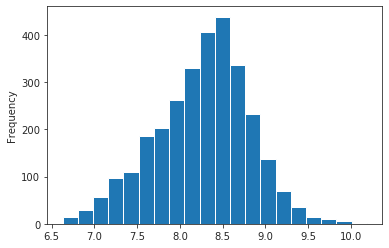

In [35]:
df_train['Word Mover Distance'].plot(kind='hist', bins=20);

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler

X = df.iloc[:,3:-1].values
y = df.iloc[:,-1].values
s = df.iloc[:,1].values

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=s)

scaler = StandardScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4173, 5), (1392, 5), (4173,), (1392,))

In [37]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import RidgeCV, Lasso
from sklearn.metrics import mean_squared_error

clf = RidgeCV().fit(X_train, y_train)

clf.score(X_train, y_train), clf.score(X_test, y_test)

(0.06513189719522139, -1.0931476777104057)

In [38]:
mean_squared_error(clf.predict(X_train), y_train), mean_squared_error(clf.predict(X_test), y_test)

(0.034866698166592255, 0.07829537130021495)

In [39]:
clf.coef_

array([-2.43258706e-02,  7.11391544e-03,  8.51445485e-05,  3.26871673e-04,
        6.09933035e-02])

### Exporting best summaries for all datasets

In [25]:
for dataset in DATASETS:
    tac = load_data(DATA_DIR, dataset, encoded=True)
    print(f'{dataset}')
    
    for topic_id, topic in tac.items():
        document_embs, summary_embs, indices, pyr_scores, summary_ids = extract(topic)

        m = np.argsort(-pyr_scores)

        embeddings = {
            'tag': f'{DATASET}:{topic_id}:System Summaries:BERT',
            'mat': np.concatenate((document_embs, summary_embs[indices[m[0],0]:indices[m[0],1]])),
            'labels': [0] * document_embs.shape[0] + [1] * summary_embs[indices[m[0],0]:indices[m[0],1]].shape[0]
        }

        make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

TAC2008
TAC2009


# Plotting BERT

In [70]:
### Load
tac = load_data(DATASET, encoded=True)

### Extract
topic = tac[TOPIC]
document_embs, summary_embs, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid scores
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

## System Summaries

### TensorBoard

In [12]:
embeddings = {
    'tag': f'{DATASET}:{TOPIC}:System Summaries:BERT',
    'mat': np.concatenate((document_embs, summary_embs[indices[m[0],0]:indices[m[0],1]])),
    'labels': [0] * document_embs.shape[0] + [1] * summary_embs[indices[m[0],0]:indices[m[0],1]].shape[0]
}

make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

### PCA

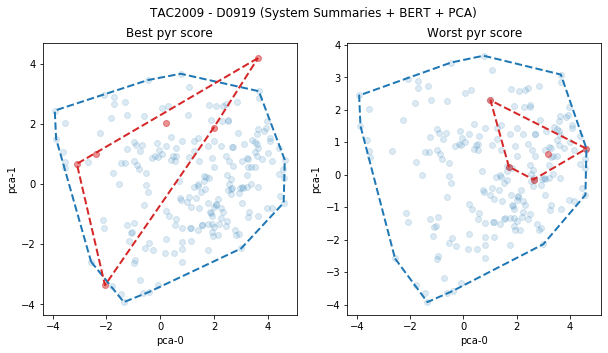

In [13]:
document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

fig = plt.figure(figsize=(10,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (System Summaries + BERT + PCA)')
ax1 = fig.add_subplot(1,2,1)
plot('pca', ax1, 'Best pyr score', document_pts, summary_pts[indices[m[0],0]:indices[m[0],1]])
ax2 = fig.add_subplot(1,2,2)
plot('pca', ax2, 'Worst pyr score', document_pts, summary_pts[indices[m[-1],0]:indices[m[-1],1]])
plt.show()

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 473 samples in 0.015s...
[t-SNE] Computed neighbors for 473 samples in 0.223s...
[t-SNE] Computed conditional probabilities for sample 473 / 473
[t-SNE] Mean sigma: 2.878953
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.332146
[t-SNE] KL divergence after 2400 iterations: 0.672893


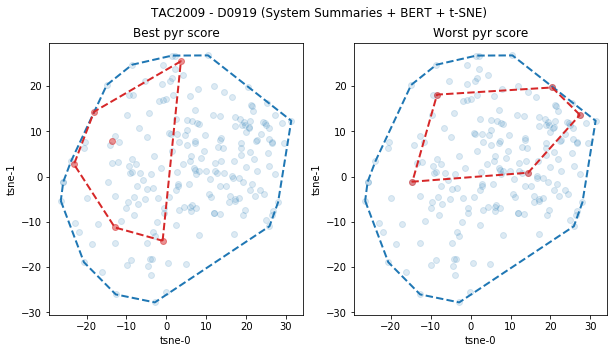

In [14]:
document_pts, summary_pts = project_tsne(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

fig = plt.figure(figsize=(10,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (System Summaries + BERT + t-SNE)')
ax1 = fig.add_subplot(1,2,1)
plot('tsne', ax1, 'Best pyr score', document_pts, summary_pts[indices[m[0],0]:indices[m[0],1]])
ax2 = fig.add_subplot(1,2,2)
plot('tsne', ax2, 'Worst pyr score', document_pts, summary_pts[indices[m[-1],0]:indices[m[-1],1]])
plt.show()

## Extractive Summarization by Maximizing Semantic Volume

In [15]:
idx = np.in1d(range(document_embs.shape[0]), max_semantic_volume_summary(document_embs, 6, distance_to_subspace))

### TensorBoard

In [16]:
embeddings = {
    'tag': f'{DATASET}:{TOPIC}:Extractive Summarization:BERT',
    'mat': document_embs,
    'labels': [0] * document_embs[~idx].shape[0] + [1] * document_embs[idx].shape[0]
}

make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

### PCA

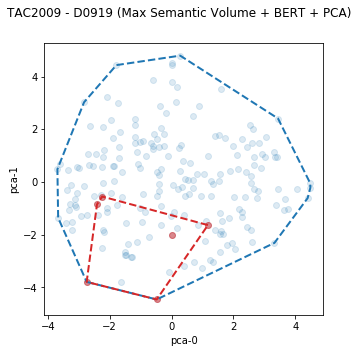

In [17]:
document_pts, _ = project_pca(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + BERT + PCA)')
ax1 = fig.add_subplot(1,1,1)
plot('pca', ax1, '', document_pts, document_pts[idx])

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 208 samples in 0.004s...
[t-SNE] Computed neighbors for 208 samples in 0.060s...
[t-SNE] Computed conditional probabilities for sample 208 / 208
[t-SNE] Mean sigma: 2.745973
[t-SNE] KL divergence after 250 iterations with early exaggeration: 62.173157
[t-SNE] KL divergence after 1050 iterations: 0.777134


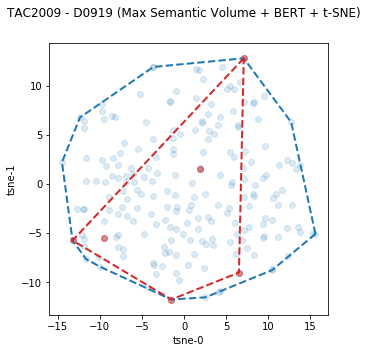

In [18]:
document_pts, _ = project_tsne(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + BERT + t-SNE)')
ax1 = fig.add_subplot(1,1,1)
plot('tsne', ax1, '', document_pts, document_pts[idx])

# Plotting SVD

In [19]:
### Load
tac = load_data(DATASET, encoded=False)

### Extract
topic = tac[TOPIC]
documents, summaries, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid socres
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.utils.extmath import randomized_svd

### Count bigrams
vectorizer = CountVectorizer(analyzer='word', ngram_range=(2,2), binary=True)
X = vectorizer.fit_transform(documents)

# If bigram b is present in s_i,
# we let s_i,b be the number of documents
# in the corpus that contain bigram b, and
# zero otherwise.
nd = X.sum(axis=0)
S = X.multiply(nd)

### Decompose
U, Sigma, VT = randomized_svd(S, n_components=100, n_iter=5, random_state=42)

# We then perform singular value decomposition (SVD)
# on S. We use U_K as the sentence representations.

In [21]:
document_embs = U

## Extractive Summarization by Maximizing Semantic Volume

In [22]:
idx = np.in1d(range(document_embs.shape[0]), max_semantic_volume_summary(document_embs, 6, distance_to_subspace))

### TensorBoard

In [23]:
embeddings = {
    'tag': f'{DATASET}:{TOPIC}:Extractive Summarization:SVD',
    'mat': document_embs,
    'labels': [0] * document_embs[~idx].shape[0] + [1] * document_embs[idx].shape[0]
}

make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_summarization'), embeddings, int(time.time()))

###  PCA

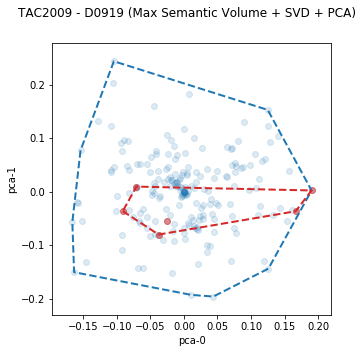

In [24]:
document_pts, _ = project_pca(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + SVD + PCA)')
ax1 = fig.add_subplot(1,1,1)
plot('pca', ax1, '', document_pts, document_pts[idx])

### t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 208 samples in 0.001s...
[t-SNE] Computed neighbors for 208 samples in 0.015s...
[t-SNE] Computed conditional probabilities for sample 208 / 208
[t-SNE] Mean sigma: 0.240379
[t-SNE] KL divergence after 250 iterations with early exaggeration: 102.293152
[t-SNE] KL divergence after 1400 iterations: 1.076915


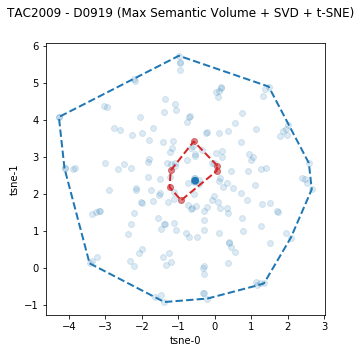

In [25]:
document_pts, _ = project_tsne(document_embs, document_embs.shape[0])

fig = plt.figure(figsize=(5,5))
fig.suptitle(DATASET + ' - ' + TOPIC + ' (Max Semantic Volume + SVD + t-SNE)')
ax1 = fig.add_subplot(1,1,1)
plot('tsne', ax1, '', document_pts, document_pts[idx])

# Interactive plot BERT

In [ ]:
from ipywidgets import interact
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

In [26]:
### Load
tac = load_data(DATASET, encoded=True)

### Extract
topic = tac[TOPIC]
document_embs, summary_embs, indices, pyr_scores = extract(topic)

### Get indices of sorted pyramid socres
m = np.argsort(-pyr_scores) # Holds sorted indices of the pyramid scores

### PCA

In [27]:
document_pts, summary_pts = project_pca(np.concatenate((document_embs, summary_embs)), document_embs.shape[0])

def make_df(pts, label):
    df = pd.DataFrame(pts, columns=['pca-0','pca-1'])
    df['label'] = label
    return df

df = pd.concat([make_df(document_pts, 'doc')] + \
               [make_df(summary_pts[indices[m[i],0]:indices[m[i],1]], f'sum-{i+1}') for i in range(len(m))], ignore_index=True)

In [28]:
@interact
def scatter_plot(label=df.label.unique()[1:]):
    df[df.label.isin(('doc',label))].iplot(kind='scatter',
                                           title=DATASET + ' - ' + TOPIC,
                                           x='pca-0',y='pca-1',
                                           mode='markers',
                                           categories='label',
                                           theme='solar',
                                           colorscale='set1')

interactive(children=(Dropdown(description='label', options=('sum-1', 'sum-2', 'sum-3', 'sum-4', 'sum-5', 'sum…